# AlexNet Note

the Alexnet is beginning of deeplearning, here we record the net structure of Alexnet.

## 1. Define AlexNet

In [17]:
class AlexNet(nn.Module):
    def __init__(self,num_classes=1000,init_weights=False):
        super(AlexNet,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 48, kernel_size = 11, stride= 4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(48, 128, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(128, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192,128, kernel_size=3, padding=1),
            nn.ReLU(inplace= True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*6*6,2048),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(2048,2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048,num_classes),
        )
        if init_weights:
            self._initialize_weights()
            
    def forward(self,x):
            x = self.features(x)
            x = torch.flatten(x,start_dim=1)
            x = self.classifier(x)
            return x
        
    def _initialize_weights(self):
            for m in self.modules():
                if isinstance(m,nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu')
                    if m.bias is not None:
                        nn.init.constant_(m.bias,0)
                    elif isinstance(m,nn.Linear):
                        nn.init.normal_(m.weight,0,0.01)
                        nn.init.constant_(m.bias,0)

## 2. 查看网络结构

In [75]:
Net = AlexNet()
summary(Net,(3,225,225),1)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 48, 55, 55]          17,472
              ReLU-2            [1, 48, 55, 55]               0
         MaxPool2d-3            [1, 48, 27, 27]               0
            Conv2d-4           [1, 128, 27, 27]         153,728
              ReLU-5           [1, 128, 27, 27]               0
         MaxPool2d-6           [1, 128, 13, 13]               0
            Conv2d-7           [1, 192, 13, 13]         221,376
              ReLU-8           [1, 192, 13, 13]               0
            Conv2d-9           [1, 192, 13, 13]         331,968
             ReLU-10           [1, 192, 13, 13]               0
           Conv2d-11           [1, 128, 13, 13]         221,312
             ReLU-12           [1, 128, 13, 13]               0
        MaxPool2d-13             [1, 128, 6, 6]               0
          Dropout-14                  [

## 3. Train AlexNet

In [18]:
net = AlexNet(num_classes=5, init_weights=True)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0002)

save_path = './AlexNet.pth'
best_acc = 0.0

for epoch in range(10):     #开始进行训练和测试，训练一轮，测试一轮
    net.train()    #训练过程中，使用之前定义网络中的dropout
    running_loss = 0.0
    t1 = time.perf_counter()
    for step, data in enumerate(train_loader, start=0):
        images, labels = data
        optimizer.zero_grad()
        outputs = net(images.to(device))
        loss = loss_function(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()      # print statistics and train process
        rate = (step + 1) / len(train_loader)
        a = "*" * int(rate * 50)
        b = "." * int((1 - rate) * 50)
        print("\rtrain loss: {:^3.0f}%[{}->{}]{:.3f}".format(int(rate * 100), a, b, loss), end="")
    print(time.perf_counter()-t1)

    # validate
    net.eval()    #测试过程中不需要dropout，使用所有的神经元
    acc = 0.0  # accumulate accurate number / epoch
    with torch.no_grad():
        for val_data in validate_loader:
            val_images, val_labels = val_data
            outputs = net(val_images.to(device))
            predict_y = torch.max(outputs, dim=1)[1]
            acc += (predict_y == val_labels.to(device)).sum().item()
        val_accurate = acc / val_num
        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)
        print('[epoch %d] train_loss: %.3f  test_accuracy: %.3f' %
              (epoch + 1, running_loss / step, val_accurate))

print('Finished Training')

train loss: 100%[**************************************************->]1.428
48.30431080000017
[epoch 1] train_loss: 1.393  test_accuracy: 0.511
train loss: 100%[**************************************************->]1.058
36.5761195999994
[epoch 2] train_loss: 1.204  test_accuracy: 0.563
train loss: 100%[**************************************************->]1.216
37.31704699999955
[epoch 3] train_loss: 1.138  test_accuracy: 0.536
train loss: 100%[**************************************************->]0.706
37.040803799999594
[epoch 4] train_loss: 1.034  test_accuracy: 0.632
train loss: 100%[**************************************************->]1.420
37.86268469999959
[epoch 5] train_loss: 0.982  test_accuracy: 0.646
train loss: 100%[**************************************************->]1.459
39.205773300000146
[epoch 6] train_loss: 0.944  test_accuracy: 0.681
train loss: 100%[**************************************************->]0.817
39.643362500000876
[epoch 7] train_loss: 0.938  test_accura

## 完整代码

roses 0.6230832934379578


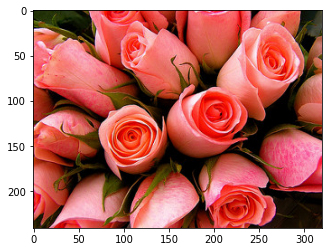

In [25]:


import torch
import torch.nn as nn
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import os
import json
import time


class AlexNet(nn.Module):
    def __init__(self,num_classes=1000,init_weights=False):
        super(AlexNet,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 48, kernel_size = 11, stride= 4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(48, 128, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(128, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192,128, kernel_size=3, padding=1),
            nn.ReLU(inplace= True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*6*6,2048),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(2048,2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048,num_classes),
        )
        if init_weights:
            self._initialize_weights()
            
    def forward(self,x):
            x = self.features(x)
            x = torch.flatten(x,start_dim=1)
            x = self.classifier(x)
            return x
        
    def _initialize_weights(self):
            for m in self.modules():
                if isinstance(m,nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu')
                    if m.bias is not None:
                        nn.init.constant_(m.bias,0)
                    elif isinstance(m,nn.Linear):
                        nn.init.normal_(m.weight,0,0.01)
                        nn.init.constant_(m.bias,0)
                        
                        
                        



#spile_data.py

import os
from shutil import copy
import random


def mkfile(file):
    if not os.path.exists(file):
        os.makedirs(file)


file = 'flower_data/flower_photos'
flower_class = [cla for cla in os.listdir(file) if ".txt" not in cla]
mkfile('flower_data/train')
for cla in flower_class:
    mkfile('flower_data/train/'+cla)

mkfile('flower_data/val')
for cla in flower_class:
    mkfile('flower_data/val/'+cla)

split_rate = 0.1
for cla in flower_class:
    cla_path = file + '/' + cla + '/'
    images = os.listdir(cla_path)
    num = len(images)
    eval_index = random.sample(images, k=int(num*split_rate))
    for index, image in enumerate(images):
        if image in eval_index:
            image_path = cla_path + image
            new_path = 'flower_data/val/' + cla
            copy(image_path, new_path)
        else:
            image_path = cla_path + image
            new_path = 'flower_data/train/' + cla
            copy(image_path, new_path)
        print("\r[{}] processing [{}/{}]".format(cla, index+1, num), end="")  # processing bar
    print()

print("processing done!")





#数据转换
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "val": transforms.Compose([transforms.Resize((224, 224)),  # cannot 224, must (224, 224)
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

#data_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))  # get data root path
data_root = os.getcwd()
image_path = data_root + "/flower_data/"  # flower data set path
train_dataset = datasets.ImageFolder(root=image_path + "/train",
                                     transform=data_transform["train"])
train_num = len(train_dataset)

# {'daisy':0, 'dandelion':1, 'roses':2, 'sunflower':3, 'tulips':4}
flower_list = train_dataset.class_to_idx
cla_dict = dict((val, key) for key, val in flower_list.items())
# write dict into json file
json_str = json.dumps(cla_dict, indent=4)
with open('class_indices.json', 'w') as json_file:
    json_file.write(json_str)

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, shuffle=True,
                                           num_workers=0)

validate_dataset = datasets.ImageFolder(root=image_path + "/val",
                                        transform=data_transform["val"])
val_num = len(validate_dataset)
validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                              batch_size=batch_size, shuffle=True,
                                              num_workers=0)

test_data_iter = iter(validate_loader)
test_image, test_label = test_data_iter.next()
#print(test_image[0].size(),type(test_image[0]))
#print(test_label[0],test_label[0].item(),type(test_label[0]))








net = AlexNet(num_classes=5, init_weights=True)


net.to(torch.device("cpu"))
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0002)

#训练参数保存路径
save_path = './AlexNet.pth'
#训练过程中最高准确率
best_acc = 0.0

#开始进行训练和测试，训练一轮，测试一轮
for epoch in range(10):
    # train
    net.train()    #训练过程中，使用之前定义网络中的dropout
    running_loss = 0.0
    t1 = time.perf_counter()
    for step, data in enumerate(train_loader, start=0):
        images, labels = data
        optimizer.zero_grad()
        outputs = net(images.to(device))
        loss = loss_function(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # print train process
        rate = (step + 1) / len(train_loader)
        a = "*" * int(rate * 50)
        b = "." * int((1 - rate) * 50)
        print("\rtrain loss: {:^3.0f}%[{}->{}]{:.3f}".format(int(rate * 100), a, b, loss), end="")
    print()
    print(time.perf_counter()-t1)

    # validate
    net.eval()    #测试过程中不需要dropout，使用所有的神经元
    acc = 0.0  # accumulate accurate number / epoch
    with torch.no_grad():
        for val_data in validate_loader:
            val_images, val_labels = val_data
            outputs = net(val_images.to(device))
            predict_y = torch.max(outputs, dim=1)[1]
            acc += (predict_y == val_labels.to(device)).sum().item()
        val_accurate = acc / val_num
        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)
        print('[epoch %d] train_loss: %.3f  test_accuracy: %.3f' %
              (epoch + 1, running_loss / step, val_accurate))

print('Finished Training')



#predict.py

data_transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# load image
img = Image.open("./flower_data/1.jpg")  #验证
plt.imshow(img)
# [N, C, H, W]
img = data_transform(img)
# expand batch dimension
img = torch.unsqueeze(img, dim=0)

# read class_indict
try:
    json_file = open('./class_indices.json', 'r')
    class_indict = json.load(json_file)
except Exception as e:
    print(e)
    exit(-1)

# create model
model = AlexNet(num_classes=5)
model_weight_path = "./AlexNet.pth"
model.load_state_dict(torch.load(model_weight_path))
model.eval()
with torch.no_grad():
    # predict class
    output = torch.squeeze(model(img))
    predict = torch.softmax(output, dim=0)
    predict_cla = torch.argmax(predict).numpy()
print(class_indict[str(predict_cla)], predict[predict_cla].item())